In [261]:
from scipy.stats import bootstrap, chi2_contingency, norm
import pandas as pd
import numpy as np 
import seaborn as sns
import pingouin as pg
import pandahouse as ph
import matplotlib.pyplot as plt

# Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Загрузка данных

In [262]:
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-ivleva/Финальный_проект/Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-ivleva/Финальный_проект/Проект_2_group_add.csv')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-ivleva/Финальный_проект/Проект_2_active_studs.csv')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-ivleva/Финальный_проект/Проект_2_checks.csv', sep=';')

 groups  - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [263]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [264]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [265]:
groups.isna().sum()

id     0
grp    0
dtype: int64

Проверяю количество наблюдений в каждой групее.

In [266]:
groups.groupby("grp").size()

grp
A    14671
B    59813
dtype: int64

groups_add - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

In [267]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [268]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [269]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [270]:
groups_add.groupby("grp").size()

grp
A    22
B    70
dtype: int64

active_studs - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [271]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [272]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [273]:
active_studs.isna().sum()

student_id    0
dtype: int64

checks - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [274]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [275]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [276]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Объединеняю groups и groups_add

In [277]:
fin_groups = pd.concat([groups, groups_add])
fin_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Количество наблюдений в каждой группе

In [278]:
fin_groups.groupby("grp").size()

grp
A    14693
B    59883
dtype: int64

Визуализирую итоговые группы

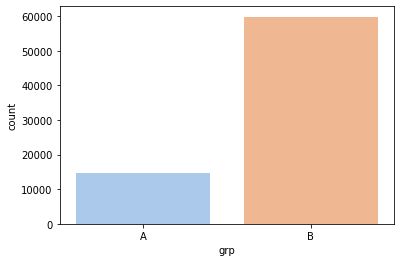

In [279]:
sns.countplot(x='grp', 
              data=fin_groups,
              order=['A', 'B'],
              palette='pastel')

Ищу пересечения между группами пользователей.

In [280]:
gr_01 = set(fin_groups.query("grp=='A'").id) 
gr_11 = set(fin_groups.query("grp=='B'").id)

gr_01.intersection(gr_11)

set()

Пересечений нет

Проверяю уникальных пользователей в группах

In [281]:
fin_groups.groupby('grp')['id'].agg(['count','nunique'])

,count,nunique
grp,,
A,14693,14693
B,59883,59883


Все пользователи в выборке уникальны. 

Проверяю процентное соотношение групп.

In [282]:
fin_groups['grp'].value_counts(normalize=True)

B    0.80298
A    0.19702
Name: grp, dtype: float64

Возникает вопрос деления на группы, обычно группы равны или тестовая группа меньше, для сокращения рисков. В данном эксперименте тестовая группа значительно превосходит контрольную, следует уточнить причины такого деления.

active_studs - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [283]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [284]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [285]:
active_studs.isna().sum()

student_id    0
dtype: int64

Переименовываю колонку для дальнейшего объединения.

In [286]:
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [287]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Проверяю количество уникальных пользователей.

In [288]:
active_studs.id.nunique()

8341

Объединяю active_groups и active_studs.

In [289]:
active_groups = active_studs.merge(fin_groups, how='inner', on='id')
active_groups.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


Проверяю количество наблюдений среди активных пользователей в каждой группе.

In [290]:
active_groups.groupby("grp").size()

grp
A    1538
B    6803
dtype: int64

Визуализирую группы активных пользователей

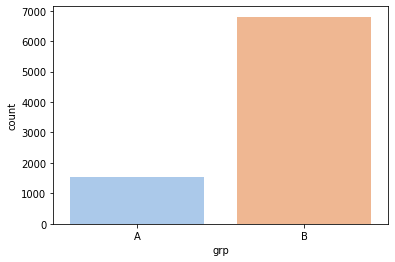

In [291]:
sns.countplot(x='grp', 
              data=active_groups,
              order=['A', 'B'],
              palette='pastel')

Переименовываю колонку для объединения с active_groups

In [292]:
checks = checks.rename(columns={'student_id': 'id'})
checks

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


Проверяю количество уникальных пользователей.

In [293]:
checks.id.nunique()

541

Все пользователи уникальны, значит на одного пользователя приходится одна оплата.

Объединяю checks и active_groups.

In [294]:
active_checks = checks.merge(active_groups, how='inner', on='id')
active_checks

,id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


Распределение по группам активных пользователей.

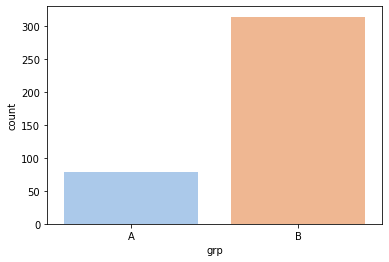

In [295]:
sns.countplot(x='grp',
              data=active_checks,
              palette='pastel')

Распределение оплат по группам активных пользователей.

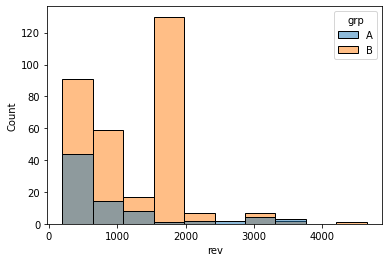

In [296]:
sns.histplot(x='rev',
             data=active_checks,
             hue='grp',
             bins=10)

Проверяю общую сумму до и после объединения.

In [297]:
checks.rev.sum()

573326.0035999999

In [298]:
active_checks.rev.sum()

467794.0035

Считаю потерянные деньги

In [299]:
checks.rev.sum() - active_checks.rev.sum()

105532.00009999995

Проверяю входят ли оплаты в экспериментальные группы (весь объем, не только активные)

In [300]:
fin_groups_checks = fin_groups.merge(checks, how='inner', on='id')
fin_groups_checks 

,id,grp,rev
0,1627,A,990.0
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
4,100300,B,990.0
...,...,...,...
536,5645737,B,1900.0
537,5651566,B,1900.0
538,5662322,B,1900.0
539,5681918,B,1900.0


Да, все оплаты от пользователей из эксперимента.

In [301]:
checks.rev.size - active_checks.rev.size

149

Получается, что в данных есть оплаты от 149 пользователей, которые не заходили в приложение. Т.к. сейчас нет возвожности выяснить каким образом они получены или это ошибка в данных, в дальнейшие расчеты их не беру. 

In [302]:
fin_groups.groupby("grp").size()

grp
A    14693
B    59883
dtype: int64

## Выбор метрик

Исходя из имеющихся данных, можно посчитать CR в покупку.

Средний доход на платящего пользователя ARPPU.

Средний доход с привлечённого пользователя ARPU.

Расчет этих метрик поможет понять бизнесу выгоду от внедрения новой механиники оплаты.

Также интересно было бы посмотреть на какой день принимается решение о покупке, как влияент механика на новых и уже существующих пользователей, но к сожалению, в имеющихся данных нет времени и дат.

#### CR в покупку.

Для расчета конверсии в покупку беру таблицу с активными пользователями (active_groups) и таблицу с оплатами (checks)

В таблицу с оплатами добавим новую колонку с "1", чтобы при дальнейшем объединении иметь возможность разделить пользователей с оплатами и без.

In [303]:
checks['payment'] = 1 

In [304]:
groups_cr = active_groups.merge(checks,
                                on='id',
                                how='left')
groups_cr.head()

,id,grp,rev,payment
0,581585,A,NaN,NaN
1,5723133,A,NaN,NaN
2,3276743,B,NaN,NaN
3,4238589,A,NaN,NaN
4,4475369,B,NaN,NaN


На места пропусков ставлю 0.

In [305]:
groups_cr = groups_cr.fillna(0)
groups_cr['payment'] = groups_cr['payment'].astype('int')
groups_cr.head()

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


Создаю таблицу для расчета CR по группам

In [306]:
df_cr = groups_cr.groupby('grp', as_index=False) \
                                    .agg({'id':'count', 'payment':'sum', 'rev': 'sum'}) \
                                    .rename(columns = {'id': 'active_id','payment': 'active_and_payment', 'rev' : 'total_sum'}) 
df_cr

,grp,active_id,active_and_payment,total_sum
0,A,1538,78,72820.0000
1,B,6803,314,394974.0035


CR для группы "A"

In [307]:
df_cr_A = df_cr.query('grp == "A"').active_and_payment / df_cr.query('grp == "A"').active_id
df_cr_A.mul(100).round(2)

0    5.07
dtype: float64

CR для группы "B"

In [308]:
df_cr_B = df_cr.query('grp == "B"').active_and_payment / df_cr.query('grp == "B"').active_id
df_cr_B.mul(100).round(2)

1    4.62
dtype: float64

##### CR групп отличаются. Теперь нужно проверить статистическую значимость этих различий.

Данные дискретные, нужно проверить распеределение на нормальность, это можно сделать с помощью normaltest.

Н0 - Распределение нормальное

H1 - Распределение отлично от нормального

In [309]:
pg.normality(data=active_checks, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


Верна гипотеза Н1, распределение отлично от нормального.

В CR категориальные данные, можно применить хи-квадрат.

Н0 - Значимых различий нет, новая механика не влияет на CR.

H1 - Значимые различия между группами есть, новая механика влияет на CR.

Делю на группы

In [310]:
grp_A = groups_cr[groups_cr['grp'] == 'A']
grp_B = groups_cr[groups_cr['grp'] == 'B']

In [311]:
grp_A.head()

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


In [312]:
grp_B.head()

,id,grp,rev,payment
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


Создаю переменные для обозначения внутри групп с оплатами и без

In [313]:
grp_A_1 = grp_A.payment.sum()
grp_A_0 = grp_A.payment.size - grp_A.payment.sum()
grp_B_1 = grp_B.payment.sum()
grp_B_0 = grp_B.payment.size - grp_B.payment.sum()

Итоговая матрица

In [314]:
cr_m = np.array([[grp_A_1, grp_A_0],
                          [grp_B_1, grp_B_0]])
cr_m

array([[  78, 1460],
       [ 314, 6489]])

Хи-квадрат

In [315]:
chi2_contingency(cr_m, correction=False)[1].round(3)

0.445

Pvalue больше 0,05, нулевая гипотеза не отклоняется, вероятно, новый способ оплаты не влияет на решение о покупке.

#### ARPPU

In [316]:
active_checks.head()

,id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B


In [317]:
active_checks.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

Медианную выручка.

In [318]:
active_checks.groupby('grp').agg({'rev': np.median})

,rev
grp,
A,585.0
B,1140.0


In [319]:
ARPPU_A = (active_checks.query('grp == "A"')
                               .rev.sum() / active_checks.query('grp == "A"')
                                                                   .id.count())
ARPPU_A.round(2)

933.59

In [320]:
ARPPU_B = (active_checks.query('grp == "B"')
                               .rev.sum() / active_checks.query('grp == "B"')
                                                                   .id.count())
ARPPU_B.round(2)

1257.88

ARPPU групп отличаются, далее проверю имеет ли это стат.значимость.

Проверка распределения на нормальность была проведена в расчете CR (используются одинаковые данные), распределение не является нормальным.

Проверка гомоменности. Использую для этого тест Левена

In [321]:
pg.homoscedasticity(active_checks, dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


Выборга гомогенна.

Исходя из полученных результатов можно использовать т-тест, т.к. соблюдается требование к гомогенности, а нормальностью можно пренебречь при выборке более 30.

Н0 - Значимых различий нет, средний доход на платящего пользователя(ARPPU) не зависит от новой механики оплаты.

H1 - Значимые различия между группами есть, новая механика влияет на ARPPU.

In [323]:
pg.ttest(x=active_checks.query("grp == 'A'").rev, 
         y=active_checks.query("grp == 'B'").rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


Pvalue меньше 0,05, нулевая гипотеза отклоняется,в группе А и В есть статистически значимые различия, значит можем предположить, что новый спосов оплаты влияет на решение о покупке.

## ARPU

Для расчета ARPU создам таблицу groups_arpu и отсутсвующие значения заменю 0 для дальнейших расчетов. 

In [324]:
groups_arpu = active_groups.merge(checks[['id', 'rev']],
                                                on='id',
                                                how='left')

groups_arpu = groups_arpu.fillna(0)

In [325]:
groups_arpu.head()

,id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Распределение оплат по группам

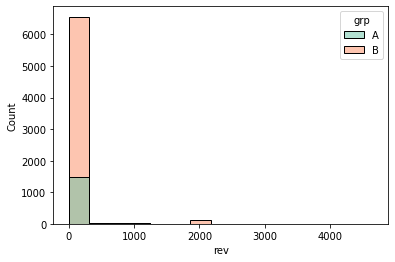

In [326]:
sns.histplot(x='rev',
             data=groups_arpu,
             hue='grp',
             bins=15,
             palette='Set2')

График показывает, что относительно общего количества участников, покупок было немного.

In [327]:
ARPU_A = (groups_arpu.query('grp == "A"')
                               .rev.sum() / groups_arpu.query('grp == "A"')
                                                                   .id.count())
ARPU_A.round(2)

47.35

In [328]:
ARPU_B = (groups_arpu.query('grp == "B"')
                               .rev.sum() / groups_arpu.query('grp == "B"')
                                                                   .id.count())
ARPU_B.round(2)

58.06

ARPU групп отличаются, далее проверю имеет ли это стат.значимость.

Проверяем выборку на нормальность и гомогенность аналогично предыдущему шагу.

In [329]:
pg.normality(data=groups_arpu, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


In [330]:
pg.homoscedasticity(groups_arpu, dv="rev", group="grp")

,W,pval,equal_var
levene,1.501461,0.220481,True


Выборка отличается от нормальной, но гоменность соблюдается, снова можно использовать т-тест.

Н0 - Значимых различий нет,средняя выручка от одного покупателя не зависит от новой механики оплаты.

H1 - Значимые различия между группами есть, новая механика влияет на ARPU.

In [68]:
pg.ttest(x=groups_arpu.query("grp == 'A'").rev, 
         y=groups_arpu.query("grp == 'B'").rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748043,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


Pvalue ,больше 0,05, нулевая гипотеза не отклоняется, можем предположить, что новая механика оплаты не влияет на ARPU

### Вывод:

Необходимо учитывать, что деление на группы в эксперименте некорректно, также информация по оплатам требует уточнения. Если есть возможность, запускаем новый тест, если нет, то после уточнения вопросов о делении групп и оплаты (если принимаем, что эти моменты несущественны) - запускаем механику на всех, т.к. ARPPU показал различия в пользу тестовой группы (1257.88 против 933.59) и т-тест подтвердил стат.значимость этих различий. Другие две метрики (CR и ARPU) не показали стат.значимых различий.


# Задание 2. SQL

Параметры подключения к clickhouse

In [69]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

#### 2.1.2 Задача
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

Данные предоставлены только за 30 и 31 октября 2021, они попадают под условия задачи, поэтому дополнительный отбор по датам не производится. 

Проверяю минимальную и максимальную дату.

In [70]:
data = '''
SELECT
    cast(MIN(timest) as DateTime) as min_date,
    cast(MAX(timest) as DateTime) as max_date
FROM peas    
LIMIT 100
'''
data = ph.read_clickhouse(data, connection=connection_default)
data

,min_date,max_date
0,2021-10-30 13:00:00,2021-10-31 17:29:52


Проверяю количество уникальных пользователей

In [71]:
peas = '''
SELECT  uniqExact(st_id) AS uniq_st_id 
FROM peas    
LIMIT 1000
'''
peas = ph.read_clickhouse(peas, connection=connection_default)
peas

,uniq_st_id
0,308



Суммирую правильно решенные горошины и группирую по ID ученика, итоговая таблица показывает нам усердных студентов.

In [72]:
df = '''
SELECT uniqExact(st_id) AS uniq_id    
FROM   
    (SELECT
        st_id,
        SUM(correct) AS total_correct
    FROM peas
    GROUP BY st_id
    HAVING SUM(correct) >= 20) 
LIMIT 1000
'''
df = ph.read_clickhouse(df, connection=connection_default)
df

,uniq_id
0,136


#### 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU, 
ARPAU, 
CR в покупку,
СR активного пользователя в покупку,
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике,
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [73]:
df2 = '''
SELECT test_grp, 
       SUM(fin_pay.total_money)/COUNT(DISTINCT studs.st_id) AS ARPU, 
       sumIf(fin_pay.total_money, fin.active_stud = 1)/SUM(active_stud) AS ARPAU,
       countIf(fin_pay.total_money > 0)/COUNT(DISTINCT studs.st_id) AS CR, 
       countIf(fin_pay.total_money > 0 
           AND fin.active_stud = 1)/SUM(fin.active_stud) AS CR_active,
       countIf(fin_pay.total_money > 0 
           AND fin.math_active_stud = 1 
           AND fin_pay.pay_math)/SUM(fin.math_active_stud) AS CR_math_active
FROM default.studs AS studs
LEFT JOIN 
    (SELECT 
        st_id, 
        SUM(money) AS total_money, -- суммируем поступившие деньги
        MAX(                       -- находим студентов, купивших курс по математике
            CASE 
            WHEN subject='Math'
            THEN true
            ELSE false
            END) AS pay_math
    FROM default.final_project_check
    GROUP BY st_id) AS fin_pay 
ON studs.st_id=fin_pay.st_id
LEFT JOIN 
    (SELECT 
           st_id, 
           (CASE 
           WHEN SUM(correct) > 10
           THEN 1
           ELSE 0
           END AS active_stud), -- студенты, выполнившие более 10 задач
           (CASE 
           WHEN countIf(subject='Math' AND correct=1)>=2
           THEN 1
           ELSE 0
           END AS math_active_stud) -- студенты, выполнившие 2 и более задачи по математике
    FROM default.peas 
    GROUP BY st_id) AS fin -- итоговая таблица
ON studs.st_id=fin.st_id
GROUP BY test_grp
'''
df2 = ph.read_clickhouse(df2, connection=connection_default)
df2

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math_active
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


# Задание 3. Python

1.Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [343]:
def calculation_of_metrics(df, df_add):
    # Переименование колонок
    new_columns = {df_add.columns[0]: 'id',
                   df_add.columns[1]: 'grp'}
    df_add = df_add.rename(columns = new_columns)
    # Дополнение таблицы новыми данными
    fin_df = pd.concat([df, df_add])
    # Расчет CR в покупку
    conversion_calculation = active_studs.merge(fin_df,
                                                how='inner',
                                                on='id')
    checks_cr = checks.copy()
    checks_cr = checks_cr.rename(columns={'student_id': 'id'})
    conversion_calculation_checks = checks_cr.merge(fin_df,
                                                how='inner',
                                                on='id')
    conversion_calculation_checks2 = conversion_calculation_checks.drop(['rev'], axis=1)
    df_cr_payment = conversion_calculation.merge(conversion_calculation_checks2,
                                                on=['id', 'grp'],
                                                how='left')
    df_cr_payment = df_cr_payment.fillna(0)
    df_cr_payment['payment'] = df_cr_payment['payment'].astype('int')
    
    A_cr_payment = df_cr_payment[df_cr_payment['grp'] == 'A']
    B_cr_payment = df_cr_payment[df_cr_payment['grp'] == 'B']
    
    A_cr_payment_1 = A_cr_payment.payment.sum()
    A_cr_payment_0 = A_cr_payment.payment.size - A_cr_payment.payment.sum()
    B_cr_payment_1 = B_cr_payment.payment.sum()
    B_cr_payment_0 = B_cr_payment.payment.size - B_cr_payment.payment.sum()
    
    cr_A = round(A_cr_payment_1 / (A_cr_payment_1 + A_cr_payment_0) * 100,2)
    cr_B = round(B_cr_payment_1 / (B_cr_payment_1 + B_cr_payment_0) * 100, 2)
    
    print(f'Конверсия в покупку группа "А": {cr_A} %')
    print(f'Конверсия в покупку группа "В" {cr_B} %'+'\n')
    
    # Расчет ARPPU
    checks_ARPPU = checks.copy()
    checks_ARPPU = checks_ARPPU.rename(columns={'student_id': 'id'})
    checks_ARPPU = checks_ARPPU[['id', 'rev']]
    active_studs_checks_ARPPU = active_groups.merge(checks_ARPPU,
                                                    on='id',
                                                    how='inner')
    A_ARPPU = active_studs_checks_ARPPU [active_studs_checks_ARPPU ['grp'] == 'A']
    B_ARPPU = active_studs_checks_ARPPU [active_studs_checks_ARPPU ['grp'] == 'B']
    A_ARPPU_fin = round(A_ARPPU.rev.sum() / A_ARPPU.rev.size, 2)
    B_ARPPU_fin = round(B_ARPPU.rev.sum() / B_ARPPU.rev.size, 2)
    
    print(f'ARPPU группа "А": {A_ARPPU_fin}')
    print(f'ARPPU группа "В": {B_ARPPU_fin}'+'\n')
    
    # Расчет ARPU
    
    checks_ARPU = checks.copy()
    checks_ARPU = checks_ARPU.rename(columns={'student_id': 'id'})
    checks_ARPU = checks_ARPU[['id', 'rev']]
    
    APRU_calculation = conversion_calculation.merge(checks_ARPU,
                                   on=['id'],
                                   how='left')
    APRU_calculation = APRU_calculation.fillna(0)
    
    A_ARPU = APRU_calculation[APRU_calculation['grp'] == 'A']
    B_ARPU = APRU_calculation[APRU_calculation['grp'] == 'B']
    A_ARPU_fin = round(A_ARPU.rev.sum() / A_ARPU.rev.size,2)
    B_ARPU_fin = round(B_ARPU.rev.sum() / B_ARPU.rev.size,2)
    
    print(f'ARPU группа "А": {A_ARPU_fin}')
    print(f'ARPU группа "В": {B_ARPU_fin}'+'\n')
    
    
    return {'Group': ['A', 'B'],
            'CR_payment, %': [cr_A, cr_B],
            'ARPPU': [A_ARPPU_fin, B_ARPPU_fin],
            'ARPU': [A_ARPU_fin, B_ARPU_fin]}    
    

In [344]:
dd = calculation_of_metrics(groups, groups_add)


Конверсия в покупку группа "А": 5.07 %
Конверсия в покупку группа "В" 4.62 %

ARPPU группа "А": 933.59
ARPPU группа "В": 1257.88

ARPU группа "А": 47.35
ARPU группа "В": 58.06



#### 2.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [346]:
def visualization(dd):
    plot_df = pd.DataFrame(dd)
    sns.set_context('talk')
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
    plt.tight_layout()
    fig.suptitle(f'Key metrics')
    sns.scatterplot(ax=axes[0], y='CR_payment, %', x='Group', data=plot_df, hue='Group', legend=False, palette ='coolwarm')
    sns.scatterplot(ax=axes[1], y='ARPPU', x='Group', data=plot_df, hue='Group', legend=False, palette ='coolwarm')
    sns.scatterplot(ax=axes[2], y='ARPU', x='Group', data=plot_df, hue='Group', legend=False, palette ='coolwarm')
    

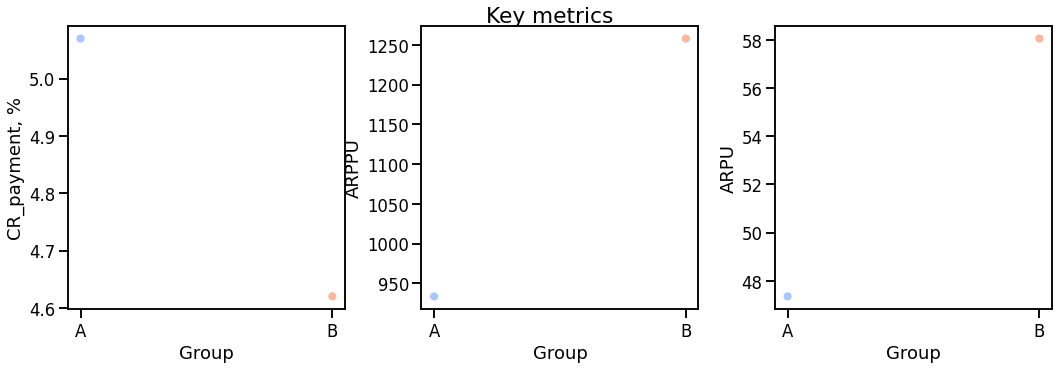

In [347]:
visualization(dd)